# Imports

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from problemStatementGenerator import *
# from dataSaverMod import *
from DataSaver import *
import time

import tensorflow as tf
from tensorflow import keras

from keras import layers
from keras import optimizers
from keras.models import Sequential

from sklearn.model_selection import train_test_split

## Notes

In [30]:
"""
    Dataset is formatted as follows:

    dataset = [lastX, lastDer, lastObj]

    We only really need lastX as it is our last iteration,
    lastDer is a float value,
    and lastObj is another array, like lastX
"""

'\n    Dataset is formatted as follows:\n\n    dataset = [lastX, lastDer, lastObj]\n\n    We only really need lastX as it is our last iteration,\n    lastDer is a float value,\n    and lastObj is another array, like lastX\n'

# Data Preprocessing

Most of this code is modified to fit the End-To-End model's needs.

The code base surrounding loading our dataset is derived from Sam's work.

In [31]:
DATA_FILE_PATH = 'Agents'

dir_list = os.listdir(DATA_FILE_PATH)
max_data_points = len(dir_list)
print("Number of data points: {}".format(len(dir_list)))
print(dir_list[0])

Number of data points: 426
Agent_851635


#### Basic DataSet Metrics

In [32]:
path = 'Agents'
AgentsToGrab = os.listdir(path)
numAgents = len(AgentsToGrab)
print("There are {} files to explore.".format(numAgents))

fx_array = []
fy_array = []
Youngs_array = []
compliance_array = []
stress_array = []  

# Pull each folder name
folderNames = [name for name in AgentsToGrab if name.startswith('Agent_')]

for folder in folderNames:
    pathToAgent = path + '/' + folder
    agentFiles = os.listdir(pathToAgent)

    # Pull subFile names
    subFiles = [name for name in agentFiles]
    
    for file in subFiles:
        if('loadConditions' in file):
            loadConditions = np.load(os.path.join(pathToAgent, file))
            #print('loadCondtions Exist')
            
            formatted = unpackLoadConditions(loadConditions)

            circles = formatted[0]
            radii = formatted[1]
            forces = formatted[2]

            nelx, nely = formatted[3], formatted[4]
            Youngs, C_max, S_max = formatted[5], formatted[6], formatted[7]
            
            fx_array.append(forces[0][0])
            fx_array.append(forces[0][1])
            fx_array.append(forces[0][2])
            fy_array.append(forces[1][0])
            fy_array.append(forces[1][1])
            fy_array.append(forces[1][2])
            
            Youngs_array.append(Youngs)
            compliance_array.append(C_max)
            stress_array.append(S_max)
            
            break

There are 426 files to explore.


In [33]:
print(np.mean(fx_array))
print(np.mean(fy_array))
print(np.mean(Youngs_array))
print(np.mean(compliance_array))
print(np.mean(stress_array))


-4.279975067166721e-15
-3.566645889305601e-14
290082085093.3325
0.0333145286566742
655274100.8008543


In [34]:
def formatStats(array):
    print("min:",np.min(array))
    print("mean:",np.mean(array))
    print("max:",np.max(array))

    print("Normalizing")
    # Forces
    # ar2 = np.array(array) 
    # ar2_mean = np.mean(np.abs(ar2))
    # ar2 = ar2 / ar2_mean
    ar2 = np.array(array) 
    ar2_mean = np.mean(ar2)
    ar2 = ar2 / ar2_mean
    print("min:",np.min(ar2))
    print("mean:",np.mean(ar2))
    print("max:",np.max(ar2))

    print(ar2_mean)

In [35]:
formatStats(stress_array)

min: 3240327.2766612205
mean: 655274100.8008543
max: 271944420515.78946
Normalizing
min: 0.004944995190105941
mean: 1.0
max: 415.0086508583629
655274100.8008543


### DataPoint Class

In [36]:
FORCE_NORMILIZATION_FACTOR = 7000
YOUNGS_MODULUS_NORMILIZATION_FACTOR = 238000000000
COMPLIANCE_MAX_NORMILIZATION_FACTOR = 0.03
STRESS_MAX_NORMILIZATION_FACTOR = 15000000

class TopOptSequence:
    def __init__(self,ID,formatted,x_array,numIterations,converged):
        self.ID = ID
        self.loadCondtions = formatted
        self.xPhys_array = x_array
        self.numIterations = numIterations
        # These two values are inverted due to the indexing nature of numpy
        self.nelx = self.loadCondtions[4] 
        self.nely = self.loadCondtions[3]
        self.converged = converged
        self.unpacked = np.empty(shape=(20,))
    
    def formatLoadConditions(self):
        circles = self.loadCondtions[0]
        radii = self.loadCondtions[1]
        forces = self.loadCondtions[2]
        nelx, nely = self.loadCondtions[3], self.loadCondtions[4]
        Youngs, C_max, S_max = self.loadCondtions[5], self.loadCondtions[6], self.loadCondtions[7]

        # print(circles.shape)
        # print(radii.shape)
        # print(forces.shape)
        
        def initUnpacked(self):
            self.unpacked[0] = circles[0][0]
            self.unpacked[1] = circles[1][0]
            self.unpacked[2] = circles[0][1]
            self.unpacked[3] = circles[1][1]
            self.unpacked[4] = circles[0][2]
            self.unpacked[5] = circles[1][2]

            self.unpacked[6] = radii[0]
            self.unpacked[7] = radii[1]
            self.unpacked[8] = radii[2]
            
            self.unpacked[9] = forces[0][0]
            self.unpacked[10] = forces[1][0]
            self.unpacked[11] = forces[0][1]
            self.unpacked[12] = forces[1][1]
            self.unpacked[13] = forces[0][2]
            self.unpacked[14] = forces[1][2]

            self.unpacked[15] = nely
            self.unpacked[16] = nely
            self.unpacked[17] = Youngs
            self.unpacked[18] = C_max
            self.unpacked[19] = S_max

        
        initUnpacked(self)        

        x = np.linspace(0,2,nelx+1)
        y = np.linspace(0,1,nely+1)
        X,Y = np.meshgrid(x,y)

        def dist(num):
            return np.sqrt((X-circles[0][num])**2 + (Y-circles[1][num])**2) - radii[num]

        circleImage = np.minimum(dist(0),np.minimum(dist(1),dist(2)))
        circleImage = np.where(circleImage >= 0, 0,1)

        circleImage = np.reshape(circleImage.T,(nelx+1,nely+1,1))

        res = min(nelx,nely)

        forceImageX = np.zeros((nelx+1,nely+1,1))
        forceImageY = np.zeros((nelx+1,nely+1,1))
        for i in range(3):
            fx = forces[0][i] / FORCE_NORMILIZATION_FACTOR
            fy = forces[1][i] / FORCE_NORMILIZATION_FACTOR
            x_coord = int(circles[0][i] * res)
            y_coord = int(circles[1][i] * res)
            forceImageX[x_coord,y_coord,0] = fx
            forceImageY[x_coord,y_coord,0] = fy

            
        #print("Y.shape:",Y.shape)

        Y_image = (Youngs / YOUNGS_MODULUS_NORMILIZATION_FACTOR )*np.ones((nelx+1,nely+1,1))
        c_max_image = (C_max / COMPLIANCE_MAX_NORMILIZATION_FACTOR )*np.ones((nelx+1,nely+1,1))
        s_max_image = (S_max / STRESS_MAX_NORMILIZATION_FACTOR )*np.ones((nelx+1,nely+1,1))

        # print("circleImage.shape:",circleImage.shape)
        # print("forceImageX.shape:",forceImageX.shape)
        # print("forceImageY.shape:",forceImageY.shape)
        # print("Y_image.shape:",Y_image.shape)
        # print("c_max_image.shape:",c_max_image.shape)
        # print("s_max_image.shape:",s_max_image.shape)

        loadCondtionsImage = np.concatenate([circleImage,forceImageX,forceImageY,Y_image,c_max_image,s_max_image],axis=2)
        return loadCondtionsImage

    def returnLastIteration(self):
        iteration = np.reshape(self.xPhys_array,(self.nelx+1,self.nely+1,1),order='F')
        formattedImage = self.formatLoadConditions()
        unpackedConditions = self.unpacked

        return iteration, formattedImage, unpackedConditions

## Loading The Dataset

In [37]:
def buildDataSet(dataPointsToGrab:int):

    # Constants of interest
    # DATA_FILE_PATH = path to agent files
    # dir_List = all agent files
    # max_data_points = total number of datapoints

    dataPointsToGrab = min(dataPointsToGrab,max_data_points)

    #randomize the data grabed so that the first thee datapoints aren't always in the data.
    indexList = np.arange(max_data_points,dtype='int32')
    np.random.shuffle(indexList)
    nonConvergedCounter = 0

    sequenceData = []
    print("Retreiving {} Datapoints.".format(dataPointsToGrab))

    for i in range(dataPointsToGrab):
        print("{:.2f}%\t\t".format((100*(i/dataPointsToGrab))),end='\r')
        try:
            #join the data file path to a random sorted member within the data directory
            pathToAgent = os.path.join(DATA_FILE_PATH,dir_list[indexList[i]])
            formated,x_array,derivatives_array,objectives_array,markName = getData(pathToAgent)
        except:
            #if an exception occurs list it and move forward
            print("Exception Occured at file '{}'.".format(os.path.join(DATA_FILE_PATH,dir_list[indexList[i]])))
            continue
        else:
            cvrg = True
            if('NotConverged' in markName):
                print("file {} has not converged.".format(dir_list[indexList[i]]))
                nonConvergedCounter += 1
                cvrg = False
            else:
                #if no error occured append that data to the data list
                sequenceData.append(TopOptSequence(i,formated,x_array,1,cvrg))

    print("100%\t\t")
    print(f"Out of {dataPointsToGrab} data points gathered, {100*(nonConvergedCounter/dataPointsToGrab)}% had not converged for a total of {nonConvergedCounter}")
    return sequenceData


### Building The Dataset

In [38]:
dataPointsToGrab = 50

if dataPointsToGrab < numAgents:
    dataPointsToGrab = numAgents

dataset = buildDataSet(dataPointsToGrab)
datasetLen = len(dataset)

Retreiving 426 Datapoints.
file Agent_608067 has not converged.
file Agent_584376 has not converged.
file Agent_226312 has not converged.
file Agent_740492 has not converged.
file Agent_12167 has not converged.
file Agent_789062 has not converged.
file Agent_567183 has not converged.
file Agent_351980 has not converged.
file Agent_349081 has not converged.
file Agent_704951 has not converged.
file Agent_883272 has not converged.
file Agent_800266 has not converged.
file Agent_342596 has not converged.
file Agent_319570 has not converged.
file Agent_295217 has not converged.
file Agent_287019 has not converged.
file Agent_974486 has not converged.
file Agent_242133 has not converged.
file Agent_927108 has not converged.
file Agent_714469 has not converged.
file Agent_908466 has not converged.
file Agent_296203 has not converged.
file Agent_2542 has not converged.
file Agent_367532 has not converged.
file Agent_547464 has not converged.
file Agent_344171 has not converged.
file Agent_723

In [39]:
dataPoint = dataset[0]
print('dataPoint.xPhys_array.shape  ', dataPoint.xPhys_array.shape)

lastIteration, conditionsImage, unpackedCondition = dataPoint.returnLastIteration()

print('type(lastIteration)          ', type(lastIteration))
print('lastIteration.shape          ', lastIteration.shape)
print('conditionsImage.shape        ' ,conditionsImage.shape)
print('type(unpackedCondition)      ', type(unpackedCondition))
print('len(unpackedCondition)       ', len(unpackedCondition))

dataPoint.xPhys_array.shape   (5151,)
type(lastIteration)           <class 'numpy.ndarray'>
lastIteration.shape           (51, 101, 1)
conditionsImage.shape         (101, 51, 6)
type(unpackedCondition)       <class 'numpy.ndarray'>
len(unpackedCondition)        20


In [40]:
print(unpackedCondition)

[ 1.72000000e+00  2.80000000e-01  5.70000000e-01  2.90000000e-01
  1.78000000e+00  6.40000000e-01  1.71042546e-01  1.75633650e-01
  1.07808815e-01  1.27581334e+04 -1.71315323e+02 -7.06310614e+02
  9.12062755e+03 -1.20518228e+04 -8.94931223e+03  5.00000000e+01
  5.00000000e+01  2.15015680e+11  4.38561432e-03  1.67822992e+07]


In [41]:
loadConditionsImage = conditionsImage
print('\nOutside function call')
# print(loadConditionsImage)
print('loadConditionsImage.shape            ', loadConditionsImage.shape)
print('loadConditionsImage[:, :, 1].shape   ', loadConditionsImage[:, :, 1].shape)

print('sum.abs circles                      ', np.sum(np.abs(loadConditionsImage[:, :, 0])))
print('sum.abs fx                           ', np.sum(np.abs(loadConditionsImage[:, :, 1])))
print('sum.abs fy                           ', np.sum(np.abs(loadConditionsImage[:, :, 2])))


Outside function call
loadConditionsImage.shape             (101, 51, 6)
loadConditionsImage[:, :, 1].shape    (101, 51)
sum.abs circles                       578.0
sum.abs fx                            3.6451809775576094
sum.abs fy                            2.6058935861498016


## Model Input Shapes

In [42]:
iterationShape = lastIteration.shape
unpackedShape = dataset[0].unpacked.shape

print('Iteration shape', iterationShape)
print('Unpacked Shape', unpackedShape)

Iteration shape (51, 101, 1)
Unpacked Shape (20,)


In [43]:
slice = loadConditionsImage[:, :, 0]
print(slice.shape)

numVals = slice.shape[0] * slice.shape[1]
count = 0

for realSol in range(slice.shape[1]-1):
    for y in range(slice.shape[0]-1):
        if slice[y, realSol] != 0:
            count += 1
            print(realSol, y, slice[y, realSol])

print(count)

(101, 51)
6 27 1.0
6 28 1.0
6 29 1.0
6 30 1.0
6 83 1.0
6 84 1.0
6 85 1.0
6 86 1.0
6 87 1.0
6 88 1.0
6 89 1.0
7 24 1.0
7 25 1.0
7 26 1.0
7 27 1.0
7 28 1.0
7 29 1.0
7 30 1.0
7 31 1.0
7 32 1.0
7 33 1.0
7 82 1.0
7 83 1.0
7 84 1.0
7 85 1.0
7 86 1.0
7 87 1.0
7 88 1.0
7 89 1.0
7 90 1.0
8 23 1.0
8 24 1.0
8 25 1.0
8 26 1.0
8 27 1.0
8 28 1.0
8 29 1.0
8 30 1.0
8 31 1.0
8 32 1.0
8 33 1.0
8 34 1.0
8 80 1.0
8 81 1.0
8 82 1.0
8 83 1.0
8 84 1.0
8 85 1.0
8 86 1.0
8 87 1.0
8 88 1.0
8 89 1.0
8 90 1.0
8 91 1.0
8 92 1.0
9 22 1.0
9 23 1.0
9 24 1.0
9 25 1.0
9 26 1.0
9 27 1.0
9 28 1.0
9 29 1.0
9 30 1.0
9 31 1.0
9 32 1.0
9 33 1.0
9 34 1.0
9 35 1.0
9 80 1.0
9 81 1.0
9 82 1.0
9 83 1.0
9 84 1.0
9 85 1.0
9 86 1.0
9 87 1.0
9 88 1.0
9 89 1.0
9 90 1.0
9 91 1.0
9 92 1.0
10 21 1.0
10 22 1.0
10 23 1.0
10 24 1.0
10 25 1.0
10 26 1.0
10 27 1.0
10 28 1.0
10 29 1.0
10 30 1.0
10 31 1.0
10 32 1.0
10 33 1.0
10 34 1.0
10 35 1.0
10 36 1.0
10 79 1.0
10 80 1.0
10 81 1.0
10 82 1.0
10 83 1.0
10 84 1.0
10 85 1.0
10 86 1.0
10 87 1.0
10

# Set up for Model Building

## Setting of General Topology Optimization Condition Parameters

In [44]:
YoungsModulusMax = 1e+12
YoungsModulusMin = 1e+9

CmaxRatio = 1e-5
CminRatio = 1e-3
ComplianceMinVal = 0

SmaxRatio = 1e+8
SminRatio = 1e+6
StressMinVal = 0

nelx, nely = 51, 101
# nelz = 26
numImageFilters = 1

#### (Testing) Building Initial Conditions 

This function is for generating a random problem statment, since we do not really have a centralized dataset, this will just have to do for now as a proof of concept. That being said, what is listed here is important for us, and while these conditions will be stored offline somewhere, the process we will follow will more than likely be the same.

All the sub-function does, is unpack the conditions and the sub-arrays that are found within it, so it is no longer an object and just a straight array. We are going to use this array to generate our noise. Doing so will allow for a 'trackable' history. Each noise array will be generated by the parameters themselves. At the moment, it is possible to have collisions, but this method can be expanded upon to create a better 'key' system. For our purposes, it will do just fine.

In [45]:
def generateProblem(nelx, nely):

    xDim, yDim = calcRatio(nelx, nely) # Length, Width

    c1, c2, c3, forces = FenicsCircleAndForceGenerator(xDim, yDim)
    Y, C_max, S_max = createConstraints(YoungsModulusMin,YoungsModulusMax,CmaxRatio,CminRatio,SmaxRatio,SminRatio)


    initial_conditions = [c1, c2, c3, forces, nelx, nely, Y, C_max, S_max]

    def unpackConditions(conditions):
        unpackedConditions = []

        circles = initial_conditions[:3]

        for x in range(3):
            for variable in circles[x]:
                unpackedConditions.append(variable)

            unpackedConditions.append(forces[0, x])
            unpackedConditions.append(forces[1, x])

        for x in range(4, len(conditions)):
            unpackedConditions.append(conditions[x])

        return unpackedConditions
    

    unpackedConditions = np.array(unpackConditions(initial_conditions))

    return unpackedConditions, initial_conditions

In [77]:
# np.random.seed(42)  # So the problem that is generated will always be the same. Comment this out for an actual random problem.
# nelx, nely = 101, 51
unpacked, packed = generateProblem(nelx, nely)
unpackedTest = np.copy(unpacked)        # This will naturally be removed when ready for production

print("\nGenerated Problem:")
print(unpacked)
print(len(unpacked))
print(unpacked.shape)

c1, c2, c3 = packed[0], packed[1], packed[2]
forces = packed[3]
nelx, nely = packed[4], packed[5]
Y, C_max, S_max = packed[6], packed[7], packed[8]


Generated Problem:
[ 7.36200000e+01  1.97300000e+01  1.95953718e-01  1.45486169e+02
  4.98918707e+03  6.06000000e+01  1.19700000e+01  1.68251636e-01
 -7.40713913e+03  2.41555781e+03  1.34000000e+00  4.69400000e+01
  1.10543658e-01  7.26165296e+03 -7.40474488e+03  1.01000000e+02
  5.10000000e+01  3.54419925e+11  9.99959570e-04  5.87427837e+07]
20
(20,)


## Creating Noise Array Based on Inital Conditions
The noise array is built off the initial conditions in 2 ways at first:
- Setting np.random.seed(x) where x:
    - x = abs(sum(cond))
- Size = (nelx, nely, len(unpacked))
    - unpacked is our conditions array, so the number of elements dictates our starting depth. Each layer within the noise array however, is a random value of (1-255), dictated by our .seed(x) value. So it's partially determined, partially random.

311688208892.4967
31168820889.249672
3116882088.9249673
(51, 101, 1)


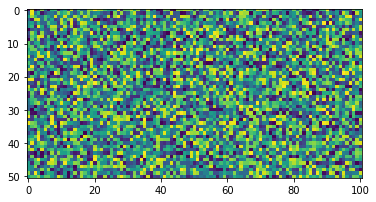

In [47]:
newSeed = np.sum(unpacked)
print(newSeed)

while newSeed > (2**32 - 1):
    newSeed /= 10
    print(newSeed)
    
newSeed = np.abs(int(newSeed)) 

np.random.seed(newSeed)

noise = np.random.randint(1, 256, size=(iterationShape))
print(noise.shape)
plt.imshow(noise[:, :, 0])

## Reshaping Random Test Data

In [48]:
# Data preparation. This is kept separate so these do not 
# continuously reshape and mess up their dimensions
unpacked = np.reshape(unpacked, newshape=(1, 20))

print('Noise Shape Before:', noise.shape)
noise = np.reshape(noise, newshape=((1,) + noise.shape))
print('Noise Shape After', noise.shape)

Noise Shape Before: (51, 101, 1)
Noise Shape After (1, 51, 101, 1)


In [49]:
print(unpacked.shape)

(1, 20)


# Model Building

### (1) Generator
The generator is a split model, such that it takes in the problem discription and the noise array and then merges to pass through several convolutional layers.
Having the split for different inputs gives us the ability to actually guide our generator, which is _exactly_ what we want.

This first generator is simply a framework to build variations off of. Simple, and flexible.

#### Model

In [50]:
print(iterationShape)
print(iterationShape[0])
print(iterationShape[1])

(51, 101, 1)
51
101


In [51]:
# Very simple Generator model framework (make changes off of this(?))
def generator():
    # Label inputs of model, this will hold (roughly) true for every architecture
    label_input = layers.Input(shape=(unpackedShape[0]), name='Label-Input')
    

    # CNN param to resize to
    nelx, nely = iterationShape[0], iterationShape[1]
    shape_0, shape_1 = nelx, nely
    n_nodes = shape_0 * shape_1

    # Label input
    labels = layers.Dense(n_nodes, name='Label-Dense')(label_input)
    labels = layers.Reshape((shape_0, shape_1, 1), name='Label-Reshape')(labels)

    # Update to n_nodes to match Gen branch
    n_nodes *= unpackedShape[0]

    # Generator noise array input model
    noise_input = layers.Input(shape=iterationShape, name='Noise-Input')


    merge = layers.Concatenate()([noise_input, labels])
    resize = layers.Resizing(height=128, width=64)(merge)


    # Layer 1
    gen = layers.Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2),
                                padding='same')(resize)
    gen = layers.ReLU()(gen)

    # Layer 2
    gen = layers.Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(1,1),
                                padding='same')(gen)
    gen = layers.ReLU()(gen)
    gen = layers.MaxPool2D(pool_size=(2,2))(gen)

    # Output & Model object
    output = layers.Conv2D(filters= 1, kernel_size=(7,7), activation='tanh',
                           padding='same')(gen)
    output = layers.Resizing(height=nelx, width=nely)(output)

    model = keras.models.Model([noise_input, label_input], output)
    
    return model

#### Model Information

In [52]:
gen1 = generator()
gen1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Label-Input (InputLayer)       [(None, 20)]         0           []                               
                                                                                                  
 Label-Dense (Dense)            (None, 5151)         108171      ['Label-Input[0][0]']            
                                                                                                  
 Noise-Input (InputLayer)       [(None, 51, 101, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Label-Reshape (Reshape)        (None, 51, 101, 1)   0           ['Label-Dense[0][0]']      

In [53]:
gen_predict = gen1((noise, unpacked), training=False)

### (1) Discriminator

Our Discriminator is also a split model. Most of the architecture will follow sorta an inverse of the discriminator, at least in terms of resolutions. While our generator creates images that end as 100x50xD (where D is the depth), our discriminator takes in images at that resolution and results in a simple classification node.

#### Model

In [54]:
def discriminator():

    label_input = layers.Input(shape=(unpackedShape[0]))

    # CNN param to resize to
    nelx, nely = iterationShape[0], iterationShape[1]
    shape_0, shape_1 = nelx, nely
    n_nodes = shape_0 * shape_1

    # Label input
    labels = layers.Dense(n_nodes, name='Label-Input')(label_input)
    labels = layers.Reshape((shape_0, shape_1, 1), name='Label-Reshape')(labels)

    # This is our input from the image
    image_input = layers.Input(shape=(iterationShape), name='Image-Input')


    merge = layers.Concatenate()([labels, image_input])

    # These next few upscale layers are here so when we resize to 128x64,
    # (ideally) more information is preserved and not lost through the resizing operation
    upscale = layers.Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2),
                                padding='same', name='Upscale-1')(merge)
    upscale = layers.ReLU(name='Upscale-1-ReLU')(upscale)

    upscale = layers.Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2),
                                padding='same', name='Upscale-2')(upscale)
    upscale = layers.ReLU(name='Upscale-2-ReLU')(upscale)


    resize = layers.Resizing(height=128, width=64)(upscale)


    dis = layers.Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), padding='same', name='Conv-1')(resize)
    dis = layers.LeakyReLU(alpha=0.2, name='ReLU-1')(dis)


    dis = layers.Conv2D(filters=128, kernel_size=(3,3), strides=(2,2), padding='same', name='Conv-2')(dis)
    dis = layers.LeakyReLU(alpha=0.2, name='ReLU-2')(dis)
    dis = layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid', name='MaxPool-1')(dis)


    dis = layers.Flatten()(dis)
    dis = layers.Dropout(0.2)(dis)


    output = layers.Dense(1, activation='sigmoid')(dis)
    # output = layers.Softmax()(output)


    model = keras.models.Model([image_input, label_input], output)
    model.compile(loss='binary_crossentropy', 
                  optimizer=optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
                  metrics=['accuracy'])
    
    return model




#### Model Information

In [55]:
dis1 = discriminator()
dis1.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 Label-Input (Dense)            (None, 5151)         108171      ['input_2[0][0]']                
                                                                                                  
 Label-Reshape (Reshape)        (None, 51, 101, 1)   0           ['Label-Input[0][0]']            
                                                                                                  
 Image-Input (InputLayer)       [(None, 51, 101, 1)  0           []                               
                                ]                                                           

Generator Input and Output
Input:  [<KerasTensor: shape=(None, 51, 101, 1) dtype=float32 (created by layer 'Noise-Input')>, <KerasTensor: shape=(None, 20) dtype=float32 (created by layer 'Label-Input')>]
Output:  KerasTensor(type_spec=TensorSpec(shape=(None, 51, 101, 1), dtype=tf.float32, name=None), name='resizing_2/resize/ResizeBilinear:0', description="created by layer 'resizing_2'")

 (1, 51, 101, 1)
(1, 20)
(1, 51, 101, 1)

Generator Image Output:


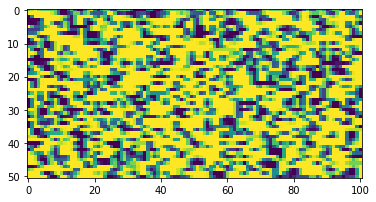



Discriminator Input and Output
Input:  [<KerasTensor: shape=(None, 51, 101, 1) dtype=float32 (created by layer 'Image-Input')>, <KerasTensor: shape=(None, 20) dtype=float32 (created by layer 'input_2')>]
Output:  KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_1/Sigmoid:0', description="created by layer 'dense_1'")
tf.Tensor([[1.]], shape=(1, 1), dtype=float32)


In [56]:
print("Generator Input and Output")
print("Input: ", gen1.input)
print("Output: ", gen1.output)


print('\n',noise.shape)
print(unpacked.shape)
gen_predict = gen1((noise, unpacked), training=False)
# print(gen_predict)
print(gen_predict.shape)

print("\nGenerator Image Output:")
plt.imshow(gen_predict[0, :, :, 0])
plt.show()

print("\n\nDiscriminator Input and Output")
print("Input: ", dis1.input)
print("Output: ", dis1.output)

dis_predict = dis1((gen_predict, unpacked), training=False)
print(dis_predict)


## cDCGAN Model
### Merging of Generator and Discriminator into a full "cDCGAN"

Here we are putting both sub-models together into one full model, essentially.
Luckily, this function is a very plug-in, shit-out, function. So our generator and discriminator are defined outside and then put together. 

**_Meaning:...._** 
##### OUR GANs CAN BE COMPOSED OF MANY DIFFERENT GENERATORS AND DISCRIMINIATORS
So in reality, we need to be creating and trying different combinations of models. Perhaps one combination performs far better than another. It will also be worth figurein

In [57]:
def full_gan(gen, dis):
    dis.trainable = False

    gen_noise, gen_label = gen.input
    gen_output = gen.output

    gan_output = dis([gen_output, gen_label])

    model = keras.models.Model([gen_noise, gen_label], gan_output)

    model.compile(loss='binary_crossentropy', 
                  optimizer=optimizers.Adam(learning_rate=0.0002, beta_1=0.5))
    
    return model

## Model Information

In [58]:
gan_model_1 = full_gan(gen1, dis1)
gan_model_1.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Label-Input (InputLayer)       [(None, 20)]         0           []                               
                                                                                                  
 Label-Dense (Dense)            (None, 5151)         108171      ['Label-Input[0][0]']            
                                                                                                  
 Noise-Input (InputLayer)       [(None, 51, 101, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Label-Reshape (Reshape)        (None, 51, 101, 1)   0           ['Label-Dense[0][0]']      

In [59]:
gan_model_output = gan_model_1((noise, unpacked), training=False)
print(gan_model_output)

tf.Tensor([[1.]], shape=(1, 1), dtype=float32)


# Side Functions:

The next few functions are here for the quick and easy creation of real_ or fake_samples, condition vectors, and noise vectors (using the generated condition vectors).

### Fake Conditions and Noise

In [60]:
def createConditionsArray(numConditions):
    conditions = []

    for x in range(numConditions):
        unpacked, _ = generateProblem(nelx, nely)
        conditions.append(unpacked)

    conditions = np.array(conditions)
    
    return conditions

conditionArray = createConditionsArray(100)
print(conditionArray.shape)

(100, 20)


In [61]:
def generateNoise(unpacked, rng):
    newSeed = np.sum(unpacked)
    # print(newSeed)

    while newSeed > (2**32 - 1):
        newSeed /= 10
        # print(newSeed)
        
    newSeed = np.abs(int(newSeed)) 

    # noise = np.random.randint(1, 256, size=(nelx, nely, len(unpacked)))
    noise = rng.standard_normal(size=(iterationShape))
    # print('Len', len(unpacked))
    # print(noise.shape)
    # plt.imshow(noise[:, :, 0])

    return noise

def createNoiseVector(conditions, numSamples, rng):
    noiseVector = []

    for x in range(numSamples):
        noise = generateNoise(conditions[x], rng)
        noiseVector.append(noise)

    return noiseVector


rng = np.random.default_rng(newSeed)

newNoise = generateNoise(unpackedTest, rng)

noiseArray = createNoiseVector(conditionArray, 100, rng)

# print(noiseArray.shape)

### Format Dataset for Model Training

In [62]:
def createDataset(data):
    unpackedCondtions = []
    finalParts = []
    conditionImages = []


    for i in range(len(data)):
        if(data[i].converged):
            finalPart, conditionImage, unpackedCondtionsPoint = data[i].returnLastIteration()
            
            finalParts.append(finalPart)
            conditionImages.append(conditionImage)
            unpackedCondtions.append(unpackedCondtionsPoint)
    
    finalParts = np.array(finalParts)
    conditionImages = np.array(conditionImages)
    unpackedCondtions = np.array(unpackedCondtions)


    return finalParts, conditionImages, unpackedCondtions


### Drawing Real and Fake Samples

In [63]:
dataPointUnpacked = dataPoint.unpacked
print(dataPointUnpacked.shape)
print(lastIteration.shape)

(20,)
(51, 101, 1)


# Creation of Split Dataset

In [64]:
data_train, data_test = train_test_split(dataset, test_size=0.3)

In [65]:
# Intermediate Test-Dataset
testFinal, testCondImages, testUnpacked = createDataset(data_train)

print(type(testFinal))
print(testFinal.shape)

print(type(testCondImages))
print(testCondImages.shape)

print(type(testUnpacked))
print(testUnpacked.shape)


<class 'numpy.ndarray'>
(241, 51, 101, 1)
<class 'numpy.ndarray'>
(241, 101, 51, 6)
<class 'numpy.ndarray'>
(241, 20)


In [66]:
index_samples = rng.integers(0, high=len(testFinal), size=(10,))

testSelected = []
print(type(index_samples))

for index in index_samples:
    testSelected.append(testFinal[index])
    print(testFinal[index])
    print(type(index))
    print(index)

print(len(testSelected))



<class 'numpy.ndarray'>
[[[0.00100503]
  [0.00067024]
  [0.00033523]
  ...
  [0.00033541]
  [0.00067024]
  [0.00067071]]

 [[0.00067024]
  [0.00067024]
  [0.00033523]
  ...
  [0.00033553]
  [0.00200804]
  [0.00067106]]

 [[0.00067024]
  [0.00067024]
  [0.00033523]
  ...
  [0.00033575]
  [0.00067024]
  [0.00067164]]

 ...

 [[0.00067024]
  [0.00067024]
  [0.00033523]
  ...
  [0.00033523]
  [0.00067041]
  [0.00067024]]

 [[0.00067024]
  [0.00200804]
  [0.00033523]
  ...
  [0.00033523]
  [0.00067044]
  [0.00067024]]

 [[0.00067024]
  [0.00067024]
  [0.00033523]
  ...
  [0.00033523]
  [0.00067053]
  [0.00100503]]]
<class 'numpy.int64'>
221
[[[4.43320480e-05]
  [2.95530334e-05]
  [1.47711192e-05]
  ...
  [1.47711192e-05]
  [2.95518018e-05]
  [2.95518018e-05]]

 [[2.95518018e-05]
  [2.95532062e-05]
  [1.47711192e-05]
  ...
  [1.47711192e-05]
  [8.86701722e-05]
  [2.95518018e-05]]

 [[2.95518018e-05]
  [2.95533423e-05]
  [1.47711193e-05]
  ...
  [1.47711192e-05]
  [2.95518018e-05]
  [2.955180

## real_samples

In [67]:
def real_samples(dataset, conditions, numSamples, rng):
    index_samples = rng.integers(0, high=len(dataset), size=(numSamples,))

    X, xConditions = [], []

    for index in index_samples:
        X.append(dataset[index])
        xConditions.append(conditions[index])



    y = np.ones((numSamples, 1))

    return [X, xConditions], y

realX, realY = real_samples(testFinal, testUnpacked, 32, rng)

print('\nlen(realX)', len(realX))
print('\ntype(realX)', type(realX))
print('\ntype(realX[0])', type(realX[0]))

print('\nlen(realY)', len(realY))
print('\ntype(realY)', type(realY))
print('\ntype(realY[0])', type(realY[0]))

realSol = realX[0]
realCon = realX[1]

print(type(realSol))
# print(solution)
print('\nlen(solution)', len(realSol))

print(type(realCon))
# print(solConditions)
print('\nlen(solConditions)', len(realCon))


x, xConditions = realSol[0], realCon[1]

print()
print(x)
print('\nx shape  ', x.shape)
print('\nlen x    ',len(x))

print()
print(xConditions)
print('\nxCond    ', xConditions.shape)
print('\nlen xCond', len(xConditions))

print()
print(x[0])
print('\nx[0]     ', x[0].shape)
print('\nxCond[0] ', xConditions[0].shape)

print('\ny shape  ', realY.shape)




len(realX) 2

type(realX) <class 'list'>

type(realX[0]) <class 'list'>

len(realY) 32

type(realY) <class 'numpy.ndarray'>

type(realY[0]) <class 'numpy.ndarray'>
<class 'list'>

len(solution) 32
<class 'list'>

len(solConditions) 32

[[[0.00057048]
  [0.00038059]
  [0.00019022]
  ...
  [0.00019022]
  [0.00038039]
  [0.00038039]]

 [[0.00038039]
  [0.00038059]
  [0.00019022]
  ...
  [0.00019022]
  [0.00114034]
  [0.00038039]]

 [[0.00038039]
  [0.00038057]
  [0.00019022]
  ...
  [0.00019022]
  [0.00038039]
  [0.00038039]]

 ...

 [[0.00038057]
  [0.00038039]
  [0.00019036]
  ...
  [0.00019022]
  [0.00038039]
  [0.00038039]]

 [[0.00038058]
  [0.00114034]
  [0.00019036]
  ...
  [0.00019022]
  [0.00038039]
  [0.00038039]]

 [[0.00038059]
  [0.00038039]
  [0.00019037]
  ...
  [0.00019022]
  [0.00038039]
  [0.00057048]]]

x shape   (51, 101, 1)

len x     51

[ 1.43000000e+00  4.70000000e-01  1.75000000e+00  5.60000000e-01
  1.10000000e+00  2.40000000e-01  1.35916985e-01  1.30015338e-01


## fake_samples

In [68]:
# def fake_samples(gen, numSamples, rng):
#     gen_preds, xConditions = [], []

#     for x in range(numSamples):
#         fakeCondition, _ = generateProblem(nelx, nely)

#         xNoise = generateNoise(fakeCondition, rng)

#         xNoise = np.reshape(xNoise, newshape=((1,) + xNoise.shape))
#         fakeCondition = np.reshape(fakeCondition, newshape=(1, len(fakeCondition)))

#         gen_prediction = gen((xNoise, fakeCondition), training=False)

#         gen_preds.append(gen_prediction)
#         xConditions.append(fakeCondition)

#     y = np.zeros((numSamples, 1))
#     y = np.reshape(1, -1)

#     return [gen_preds, xConditions], y    


def fake_samples(gen, numSamples, rng):
    noiseVector, xConditions = [], []

    for x in range(numSamples):
        fakeCondition, _ = generateProblem(nelx, nely)
        fakeCondition = np.reshape(fakeCondition, newshape=(len(fakeCondition)))

        xConditions.append(fakeCondition)
        noise = generateNoise(fakeCondition, rng)

        noiseVector.append(noise)


    y = np.zeros((numSamples, 1))

    return [noiseVector, xConditions], y    


fakeX, fakeY = fake_samples(gen1, 32, rng)
print('\nlen(fakeX)', len(fakeX))
print('\ntype(fakeX)', type(fakeX))
print('\nlen(fakeY)', len(fakeY))
print('\ntype(fakeY)', type(fakeX))

fakeSol = fakeX[0]
fakeCon = fakeX[1]

print('\ntype(fakeSol)', type(fakeSol))
print('\nlen(fakeSol)', len(fakeSol))
# print('\nfakeSol.shape', fakeSol.shape)
print('\nfakeSol[0].shape', fakeSol[0].shape)
print('\btype(fakeSol[0])', type(fakeSol[0]))
print('\nfakeSol[0]', fakeSol[0])

print('\nlen(fakeCon)', len(fakeCon))
# print('\nfakeCon.shape', fakeCon.shape)
print('\nfakeCon[0].shape', fakeCon[0].shape)
print('\ntype(fakeCon[0])', type(fakeCon[0]))
print('\nfakeCon[0]', fakeCon[0])



len(fakeX) 2

type(fakeX) <class 'list'>

len(fakeY) 32

type(fakeY) <class 'list'>

type(fakeSol) <class 'list'>

len(fakeSol) 32

fakeSol[0].shape (51, 101, 1)
type(fakeSol[0]) <class 'numpy.ndarray'>

fakeSol[0] [[[-0.01672228]
  [ 1.33553019]
  [-0.03585134]
  ...
  [ 0.73869041]
  [-0.14420866]
  [ 0.88955139]]

 [[-0.80532283]
  [ 1.09247272]
  [-0.61089204]
  ...
  [ 0.26334692]
  [ 0.82405889]
  [-0.08781477]]

 [[ 1.22968349]
  [ 0.18981374]
  [-0.19727622]
  ...
  [ 0.10371202]
  [-0.84068452]
  [-1.27190496]]

 ...

 [[-0.14822122]
  [-1.09580435]
  [-0.09217492]
  ...
  [-0.45396754]
  [-0.72889722]
  [-0.91930576]]

 [[-0.85338693]
  [ 1.74829112]
  [ 0.03470485]
  ...
  [-1.49133914]
  [ 0.5588968 ]
  [ 0.83429738]]

 [[ 1.55819436]
  [-1.05724556]
  [-0.22028814]
  ...
  [ 0.37136957]
  [-1.56557866]
  [ 0.74439382]]]

len(fakeCon) 32

fakeCon[0].shape (20,)

type(fakeCon[0]) <class 'numpy.ndarray'>

fakeCon[0] [ 1.71600000e+01  1.70900000e+01  1.39264980e-01  5.657205

# Training

In [69]:
# fakeSol = tf.convert_to_tensor(np.array(fakeSol))
# print(len(fakeSol))
# print(fakeSol)

# fakeCon = tf.convert_to_tensor(fakeCon)
# print(len(fakeCon))

# gen_preds = gen1((fakeSol, fakeCon), training=False)

realSol = tf.convert_to_tensor(np.array(realSol))
realCon = tf.convert_to_tensor(np.array(realCon))

gen_preds = gen1((realSol, realCon), training=False)

print(gen_preds)

tf.Tensor(
[[[[ 0.509804  ]
   [ 0.73063487]
   [ 0.9587459 ]
   ...
   [-0.8729351 ]
   [-0.17035764]
   [ 0.509804  ]]

  [[ 1.        ]
   [ 1.        ]
   [ 1.        ]
   ...
   [-0.47058773]
   [ 0.3375051 ]
   [ 1.        ]]

  [[-1.        ]
   [-0.09900999]
   [ 1.        ]
   ...
   [ 1.        ]
   [ 0.14880848]
   [-0.5490198 ]]

  ...

  [[ 0.54901123]
   [ 0.7521794 ]
   [ 1.        ]
   ...
   [-1.        ]
   [ 0.09900665]
   [ 1.        ]]

  [[ 1.        ]
   [ 1.        ]
   [ 1.        ]
   ...
   [-1.        ]
   [ 0.09900665]
   [ 1.        ]]

  [[ 1.        ]
   [ 1.        ]
   [ 1.        ]
   ...
   [-0.50979614]
   [ 0.31984186]
   [ 1.        ]]]


 [[[ 0.509804  ]
   [ 0.73063487]
   [ 0.9587459 ]
   ...
   [-0.8729351 ]
   [-0.17035764]
   [ 0.509804  ]]

  [[ 1.        ]
   [ 1.        ]
   [ 1.        ]
   ...
   [-0.47058773]
   [ 0.3375051 ]
   [ 1.        ]]

  [[-1.        ]
   [-0.09900999]
   [ 1.        ]
   ...
   [ 1.        ]
   [ 0.14880848]


In [70]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Defining Loss Functions

In [71]:
def disciminator_loss(real_output, fake_output, y_real, y_fake):
    real_loss = cross_entropy(y_real, real_output)
    fake_loss = cross_entropy(y_fake, fake_output)

    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output, y_fake):
    return cross_entropy(y_fake, fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Train Step and Train

In [72]:
n_epochs=10
n_batch=64
n_eval=200

half_batch = int(n_batch / 2)
print(half_batch)


@tf.function
def train_step(gen, dis, dataset, conditions, half_batch, rng):

    realX, y_real = real_samples(dataset, conditions, half_batch, rng)
    
    X_real, cond_real = realX[0], realX[1]
    X_real = tf.convert_to_tensor(X_real, dtype=np.float64)
    cond_real = tf.convert_to_tensor(cond_real, dtype=np.float64)
    
    
    fakeX, y_fake = fake_samples(gen, half_batch, rng) 
    
    X_fake, cond_fake = fakeX[0], fakeX[1]
    X_fake = tf.convert_to_tensor(np.array(X_fake), dtype=np.float64)
    cond_fake = tf.convert_to_tensor(np.array(cond_fake), dtype=np.float64)


    with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
        generated_images = gen((X_fake, cond_fake), training=True)

        real_output = dis((X_real, cond_real), training=True)
        fake_output = dis((generated_images, cond_fake), training=True)

        
        gen_loss = generator_loss(fake_output, y_fake)
        disc_loss = disciminator_loss(real_output, fake_output, y_real, y_fake)

    gradients_of_generator = gen_tape.gradient(gen_loss, gen.trainable_variables)
    gradients_of_discriminator = dis_tape.gradient(disc_loss, dis.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, gen.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, dis.trainable_variables))




32


In [73]:
def train(gen, dis, dataset, conditions, rng, n_epochs=5, n_batch=64, n_eval=200):
    # batch_per_epoch = int(dataset.shape[0] / n_batch)
    batch_per_epoch = int(len(dataset) / n_batch)
    print(len(dataset))
    print(batch_per_epoch)

    half_batch = int(n_batch / 2)

    for i in range(n_epochs):
        start = time.time()
        
        for j in range(batch_per_epoch):
            print("Call")
            train_step(gen, dis, dataset, conditions, half_batch, rng)

        print ('Time for epoch {} is {} sec'.format(i + 1, time.time()-start))
        

## Load Dataset and Pass to Model

### TrainModel

In [74]:
def TrainModel(gen, dis, data, rng):
    finalParts, conditionImages, unpackedConditions = createDataset(data)

    print('finalParts.shape         ', finalParts.shape)
    print('conditionImages.shape    ', conditionImages.shape)
    print('unpackedConditions.shape ', unpackedConditions.shape)

    train(gen, dis, finalParts, unpackedConditions, rng)    

TrainModel(gen1, dis1, data_train, rng)

finalParts.shape          (241, 51, 101, 1)
conditionImages.shape     (241, 101, 51, 6)
unpackedConditions.shape  (241, 20)
241
3
Call
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


/Users/kylecrisp/Library/Python/3.7/lib/python/site-packages/keras/backend.py:5677: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits, "Sigmoid", "binary_crossentropy"


Call
Call
Time for epoch 1 is 112.52205491065979 sec
Call
Call
Call
Time for epoch 2 is 88.63728880882263 sec
Call
Call
Call
Time for epoch 3 is 77.89408993721008 sec
Call
Call
Call
Time for epoch 4 is 72.90657877922058 sec
Call
Call
Call
Time for epoch 5 is 76.77666902542114 sec


## Creation of Testing Dataset

In [75]:
testFinal, testCondImages, testUnpacked = createDataset(data_test)

[testX, testCond], testY = real_samples(testFinal, testUnpacked, 1, rng)

testX = tf.convert_to_tensor(testX)
testCond = tf.convert_to_tensor(testCond)

testPredict = gen1((testX, testCond), training=False)

(1, 51, 101, 1)


<function matplotlib.pyplot.show(close=None, block=None)>

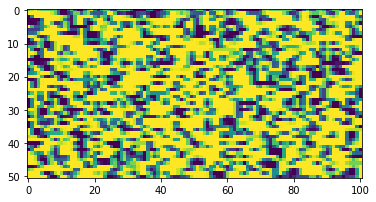

In [76]:
print(testPredict.shape)

plt.imshow(testPredict[0, :, :, 0])
plt.show